In [1]:
import bbmaster as mst
import numpy as np
import matplotlib.pyplot as plt
import pymaster as nmt
import healpy as hp 

### 0. Exciting polarization modes in maps
Producing polarized delta sims with `healpy` is slightly less trivial than for a scalar field, since setting the temperature - polarization cross correlation to zero actually suppresses the polarized mode. E.g. exciting $E$ therefore requires setting both $EE$ and $TE$ to one, which is fine as long as we don't care about $T$.

### 1. Setup
- Read mask.
- Define bandpower bins
- Initialize bandpower window function calculator

/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 64
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


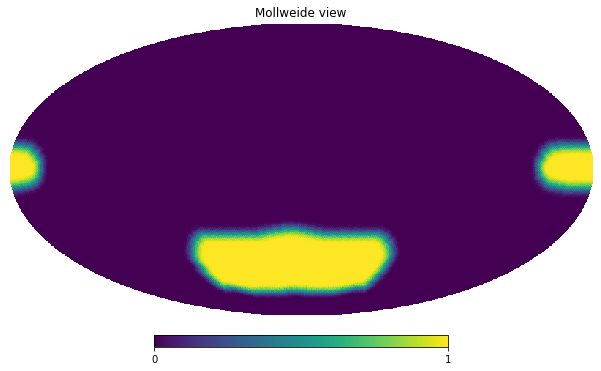

In [2]:
# Read mask
nside = 64
#msk = hp.read_map("../SensitivityCheck/data/mask_apodized.fits")
msk = hp.read_map("/global/cscratch1/sd/kwolz/BBPower/examples/data/maps/mask_bin_apo10.0_nside64.fits")
hp.mollview(msk)

# Generate NaMaster bins
b = nmt.NmtBin(nside, nlb=10)
# Bbl calculator
# Dictionary defining method to generate delta sims (not many options yet!)
dsim = {'stats': 'Gaussian'}
# Dictionary defining method to filter (just masking for now)
filt = {'mask': msk}
bc = mst.DeltaBbl(nside, dsim, filt, b, pol=True, interp_ells=5)

In [3]:
for im, ip, rn in bc._rands_iterator():
    print(f'{im} {ip} {rn}')

0 0 [0, 1]
1 0 [0, 2]
0 1 [0, 1]
1 1 [2, 0]
0 2 [0, 1]
1 2 [1, 2]
0 3 [0, 1]
1 3 [2, 1]


### 2. Compute exact bandpowers
Now let's use NaMaster to compute the exact bandpower windows, and plot them

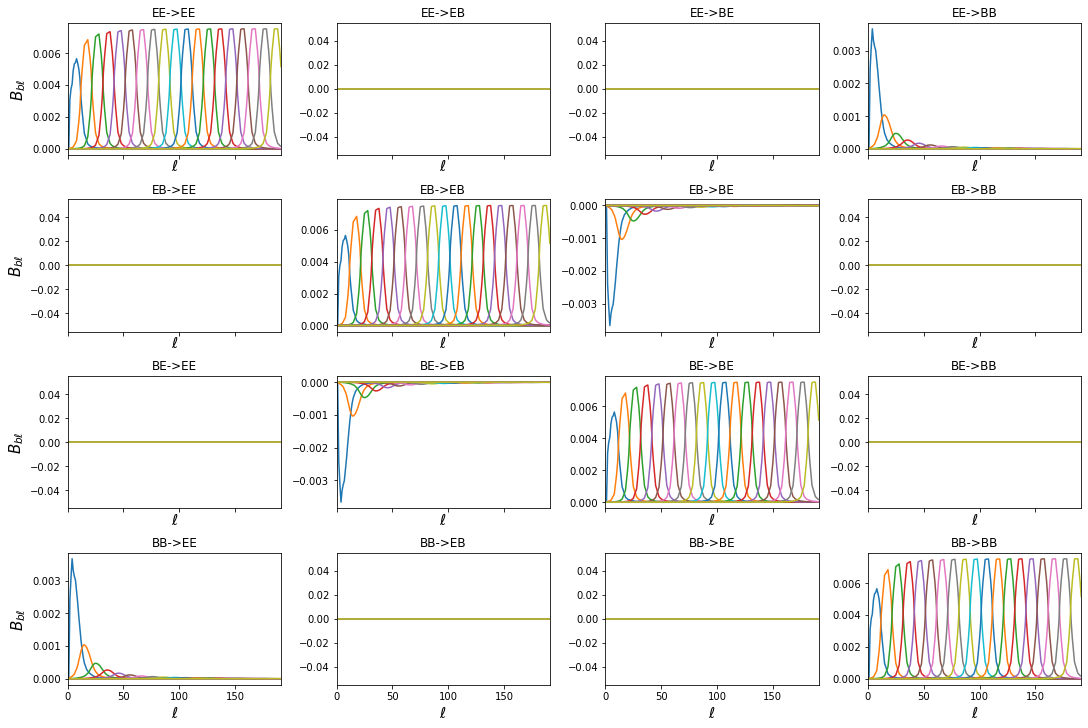

In [3]:
# Spin-2 field
f = nmt.NmtField(hp.ud_grade(msk, nside_out=nside), None, spin=2)
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f, f, b)
mcm = w.get_coupling_matrix()

def get_grid_axes():
    nbins=4
    fig, axes = plt.subplots(nbins, nbins,
                             figsize=(15, 10),
                             constrained_layout=True,
                             sharex=True)
    return fig, axes

# MCM has dimensions (pol_out, bpw_out, pol_in, ell_in) 
bpw_true = np.zeros((4,bc.n_bins,4,3*nside))
fig, axes = get_grid_axes()

for ip, p in enumerate(['EE', 'EB', 'BE', 'BB']):
    for iq, q in enumerate(['EE', 'EB', 'BE', 'BB']):
        ax = axes[iq, ip]
        # The assumed ordering of power spectra is such that the l-th element 
        # of the i-th power spectrum be stored with index l * n_cls + i.
        idx_p = [l*4+ip for l in range(3*nside)]
        idx_q = [l*4+iq for l in range(3*nside)]
        mcm_pq = mcm[np.ix_(idx_p,idx_q)]
        #print(mcm_pq.shape)
        #print(mcm_pq.T[0].shape)
        bpw_true[ip,:,iq,:] = np.array([b.bin_cell(m) for m in mcm_pq.T]).T
        for ib in range(bc.n_bins):
            ax.set_title(f'{q}->{p}')
            ax.plot(bpw_true[ip,ib,iq,:])
        ax.set_xlim([0, 3*nside-1])
        ax.set_xlabel('$\ell$', fontsize=15)
        if ip==0:
            ax.set_ylabel('$B_{b\ell}$', fontsize=15)
plt.show()


### 3. Compute bandpower windows through simulations

In [5]:
%%time
bpw_num = bc.gen_Bbl_all()

ell=2/191: sim 0 of 10

/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


ell=187/191: sim 9 of 10CPU times: user 5min 1s, sys: 3.18 s, total: 5min 5s
Wall time: 2min 33s


Now compute them using Z2 sims

In [6]:
%%time
dsim = {'stats': 'Z2'}
bc_z2 = mst.DeltaBbl(nside, dsim, filt, b, pol=True, interp_ells=5)
bpw_num_z2 = bc_z2.gen_Bbl_all()
print(bpw_num_z2.shape)

ell=187/191: sim 9 of 10(4, 19, 4, 190)
CPU times: user 4min 57s, sys: 2.77 s, total: 4min 59s
Wall time: 2min 30s


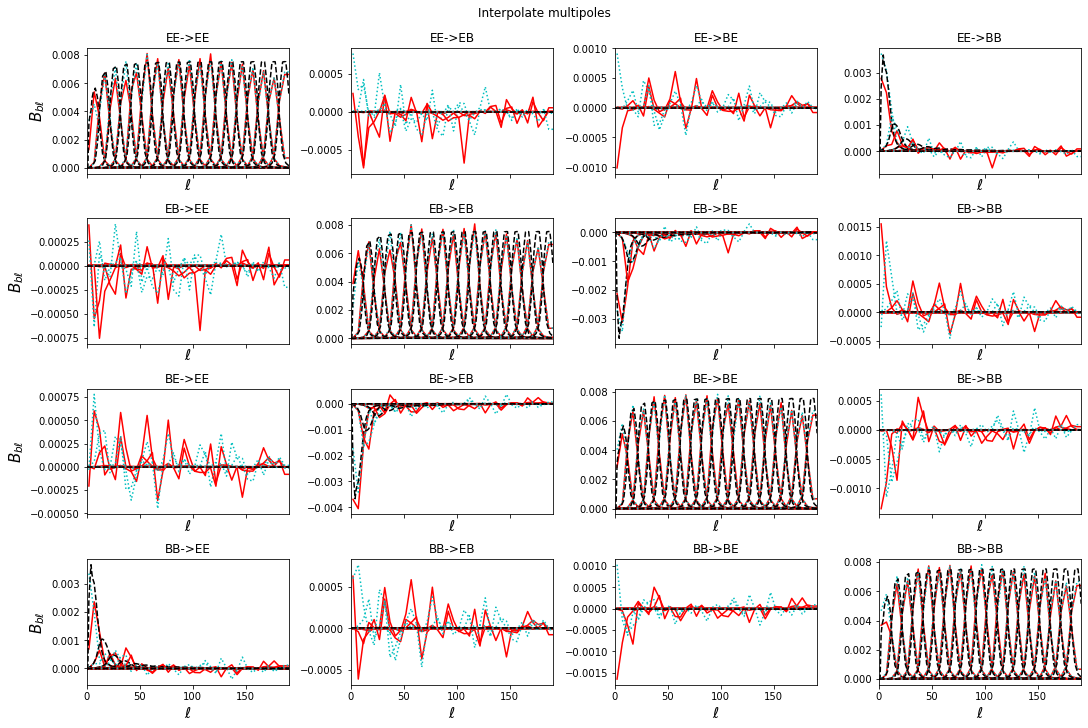

In [9]:
fig, axes = get_grid_axes()

for ip, p in enumerate(['EE', 'EB', 'BE', 'BB']):
    for iq, q in enumerate(['EE', 'EB', 'BE', 'BB']):
        ax = axes[iq, ip]
        # BPW matrices have dimensions (pol_out, bpw_out, pol_in, ell_in) 
        ax.set_title(f'{q}->{p}')    
        for ib in range(bc.n_bins):
            ax.plot(bc.get_ells(), bpw_num[iq,ib,ip,:], 'r-')
            ax.plot(bc_z2.get_ells(), bpw_num_z2[iq,ib,ip,:], 'c:')
            ax.plot(bpw_true[iq,ib,ip,:], 'k--')
        ax.set_xlim([0, 3*nside-1])
        ax.set_xlabel('$\ell$', fontsize=15)
        if ip==0:
            ax.set_ylabel('$B_{b\ell}$', fontsize=15)
plt.suptitle("Interpolate multipoles")
plt.show()

Note that when setting `interp_ells=5` (only sample every 5th multipole and interpolate the others), we clearly see that Z2 variables are superior to Gaussian variables at low $\ell$.

Now, let's test other bandpower widths.

In [4]:
b20 = nmt.NmtBin(nside, nlb=20)
# Bbl calculator
dsim = {'stats': 'Gaussian'}
filt = {'mask': msk}
bc20 = mst.DeltaBbl(nside, dsim, filt, b20, pol=True)

In [5]:
w20 = nmt.NmtWorkspace()
w20.compute_coupling_matrix(f, f, b20)
mcm20 = w20.get_coupling_matrix()

# MCM has dimensions (pol_out, bpw_out, pol_in, ell_in) 
bpw20_true = np.zeros((4,bc20.n_bins,4,3*nside))

for ip, p in enumerate(['EE', 'EB', 'BE', 'BB']):
    for iq, q in enumerate(['EE', 'EB', 'BE', 'BB']):
        ax = axes[iq, ip]
        # The assumed ordering of power spectra is such that the l-th element 
        # of the i-th power spectrum be stored with index l * n_cls + i.
        idx_p = [l*4+ip for l in range(3*nside)]
        idx_q = [l*4+iq for l in range(3*nside)]
        mcm_pq = mcm20[np.ix_(idx_p,idx_q)]
        bpw20_true[ip,:,iq,:] = np.array([b20.bin_cell(m) for m in mcm_pq.T]).T

In [6]:
%%time
bpw20_num = bc20.gen_Bbl_all()

ell=2/191: sim 0 of 10

/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/k/kwolz/.conda/envs/bbpower/lib/python3.6/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


ell=191/191: sim 9 of 10CPU times: user 25min 10s, sys: 15 s, total: 25min 25s
Wall time: 12min 46s


In [7]:
%%time
dsim = {'stats': 'Z2'}
bc20_z2 = mst.DeltaBbl(nside, dsim, filt, b20, pol=True)
bpw20_num_z2 = bc20_z2.gen_Bbl_all()

ell=191/191: sim 9 of 10CPU times: user 25min, sys: 14.7 s, total: 25min 15s
Wall time: 12min 41s


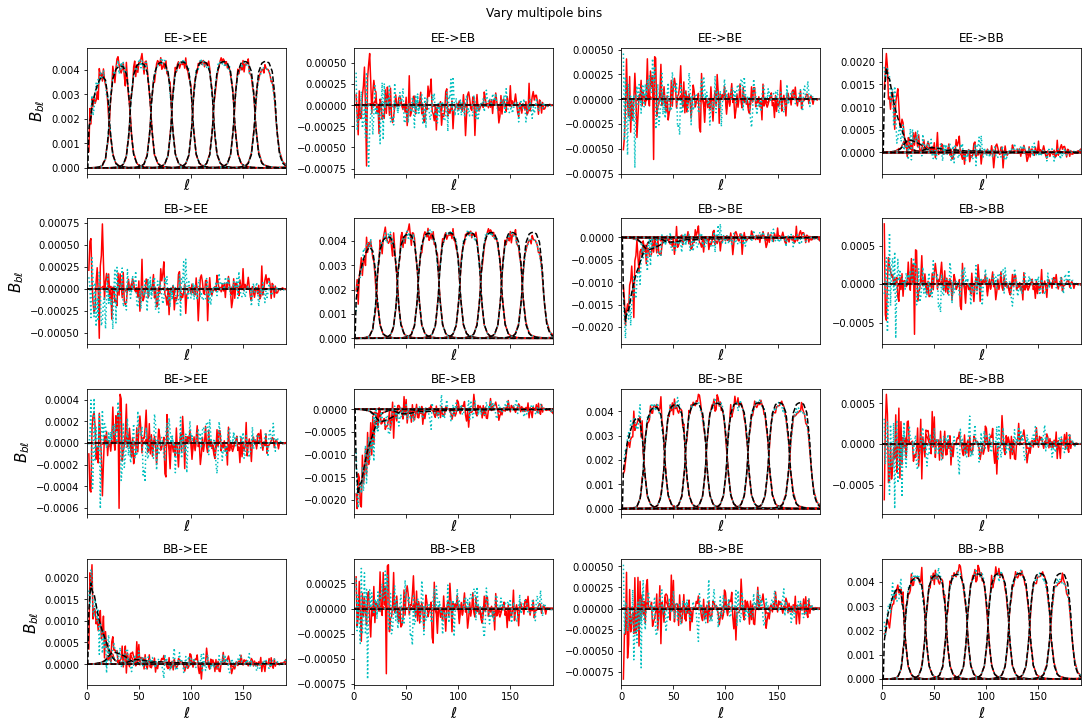

In [8]:
fig, axes = get_grid_axes()

for ip, p in enumerate(['EE', 'EB', 'BE', 'BB']):
    for iq, q in enumerate(['EE', 'EB', 'BE', 'BB']):
        ax = axes[iq, ip]
        # BPW matrices have dimensions (pol_out, bpw_out, pol_in, ell_in) 
        ax.set_title(f'{q}->{p}')    
        for ib in range(bc20.n_bins):
            ax.plot(bc20.get_ells(), bpw20_num[iq,ib,ip,:], 'r-')
            ax.plot(bc20_z2.get_ells(), bpw20_num_z2[iq,ib,ip,:], 'c:')
            ax.plot(bpw20_true[iq,ib,ip,:], 'k--')
        ax.set_xlim([0, 3*nside-1])
        ax.set_xlabel('$\ell$', fontsize=15)
        if ip==0:
            ax.set_ylabel('$B_{b\ell}$', fontsize=15)
plt.suptitle("Vary multipole bins")
plt.show()

In [8]:
# Next steps:
# * Only sample fraction of ells and interpolate to gain speed  OK
# * Vary bandpowers & check                                     OK
# * Implement chi2 measure of bandpower accuracy                TODO
# * Load test CMB signal and reconstruct observed bandpowers    TODO
# * Implement r likelihood and make Fisher forecast             TODO